ADF Test Statistic: -17.811799904998683
p-value: 3.1869943993395085e-30
Critical Values: {'1%': -3.433519140120394, '5%': -2.862939980034572, '10%': -2.567515285397938}
Is Stationary: True


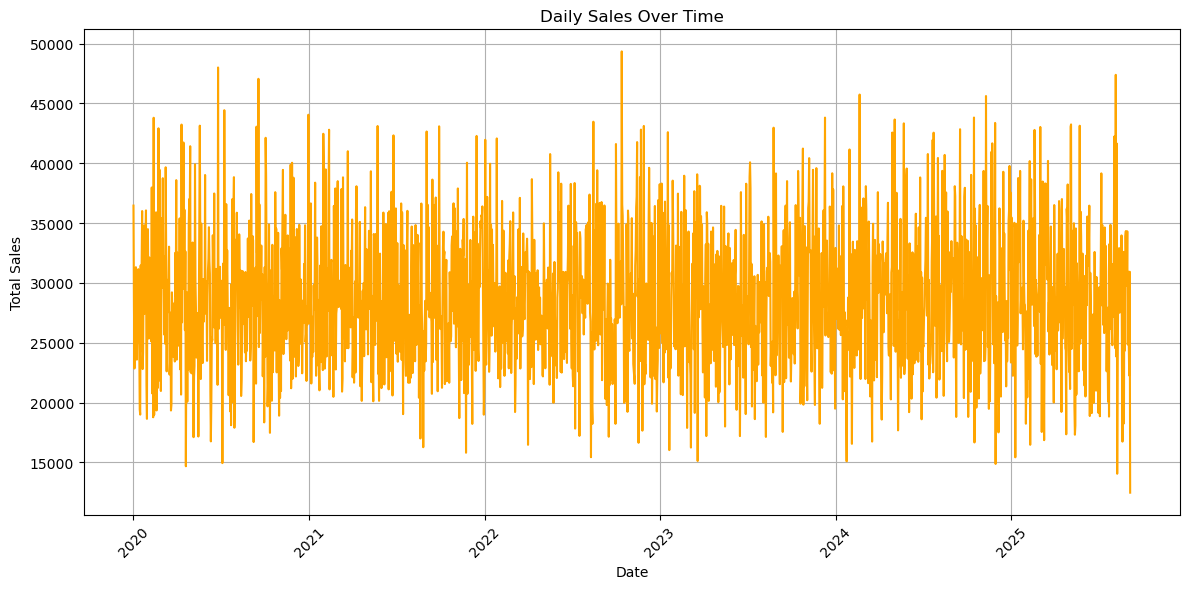

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Load the dataset
df = pd.read_csv("online_sales_dataset.csv")  

# Convert 'InvoiceDate' to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Filter out negative or zero quantities 
df = df[df['Quantity'] > 0]

# Create a 'Sales' column
df['Sales'] = df['Quantity'] * df['UnitPrice']

# Aggregate total daily sales
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['Sales'].sum()

# Reindex to ensure all dates are covered (fill missing with 0)
full_range = pd.date_range(start=daily_sales.index.min(), end=daily_sales.index.max(), freq='D')
daily_sales = daily_sales.reindex(full_range, fill_value=0)

# Run ADF Test (Augmented Dickey-Fuller)
adf_result = adfuller(daily_sales)
print("ADF Test Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])
print("Is Stationary:", adf_result[1] < 0.05)

# Plot the time series
plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_sales.index, y=daily_sales.values, color='orange')
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

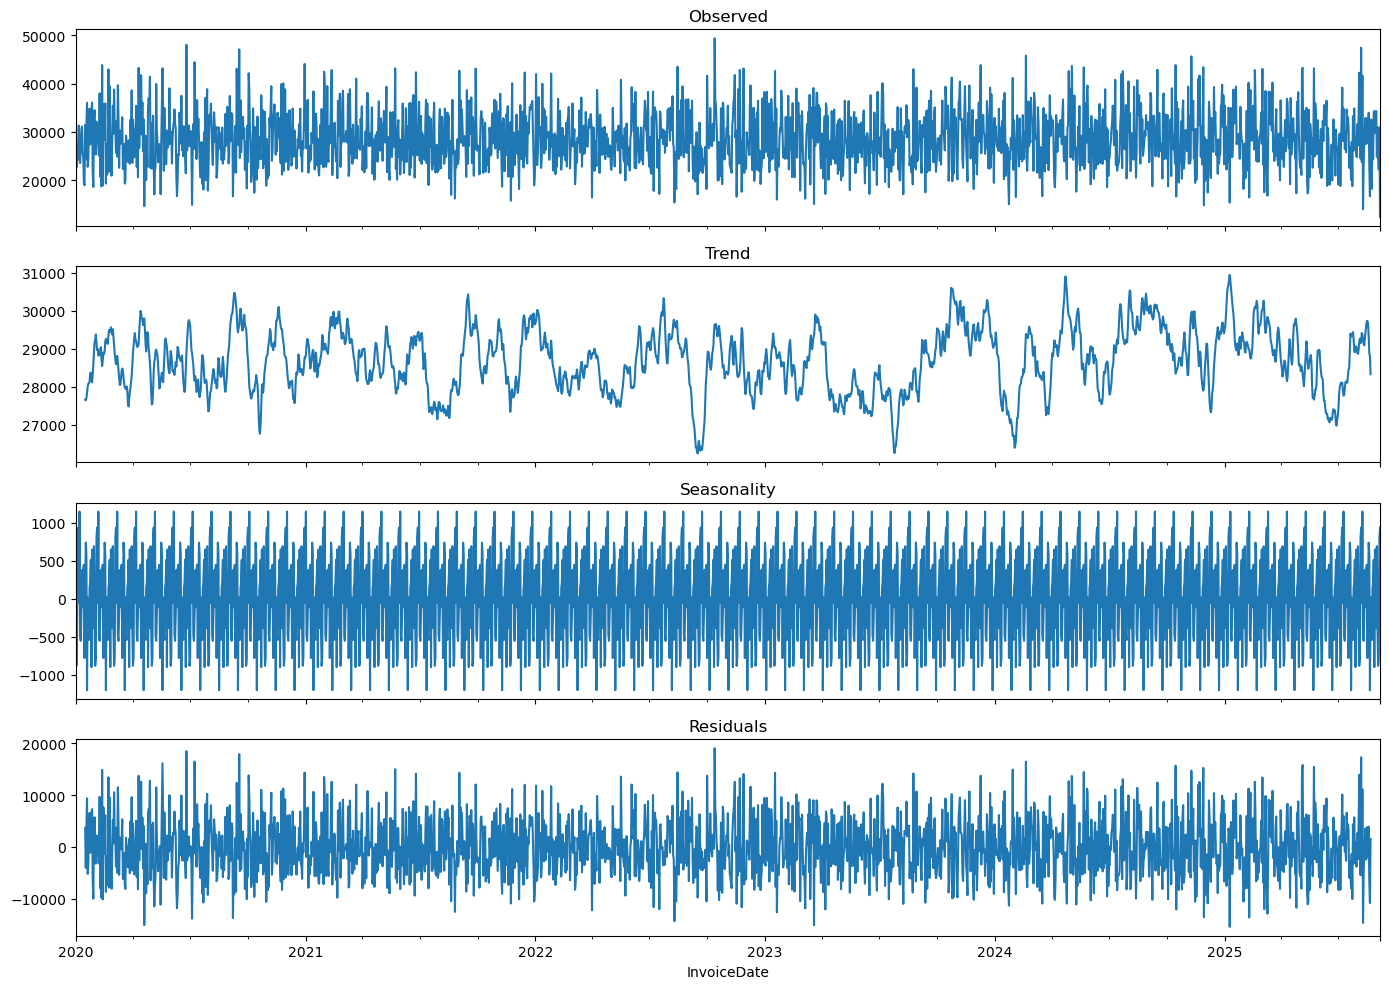

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load and prepare the dataset 
df = pd.read_csv("online_sales_dataset.csv")  
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[df['Quantity'] > 0]  # Remove returns or invalid data
df['Sales'] = df['Quantity'] * df['UnitPrice']

# Aggregate daily sales
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['Sales'].sum()

# Fill missing dates
daily_sales.index = pd.to_datetime(daily_sales.index)
daily_sales = daily_sales.asfreq('D', fill_value=0)

# Decompose the time series (assuming monthly seasonality: 30 days)
decomposition = seasonal_decompose(daily_sales, model='additive', period=30)

# Plot decomposition components
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonality')
decomposition.resid.plot(ax=axes[3], title='Residuals')

plt.tight_layout()
plt.show()



In [9]:
!pip install pmdarima


   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   --------------------------------------  624.6/625.1 kB 41.0 MB/s eta 0:00:01
   --------------------------------------- 625.1/625.1 kB 13.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   -------------------------- ------------- 1.9/2.8 MB 60.1 MB/s eta 0:00:01
   ---------------------------------------  2.8/2.8 MB 59.0 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 35.7 MB/s eta 0:00:00


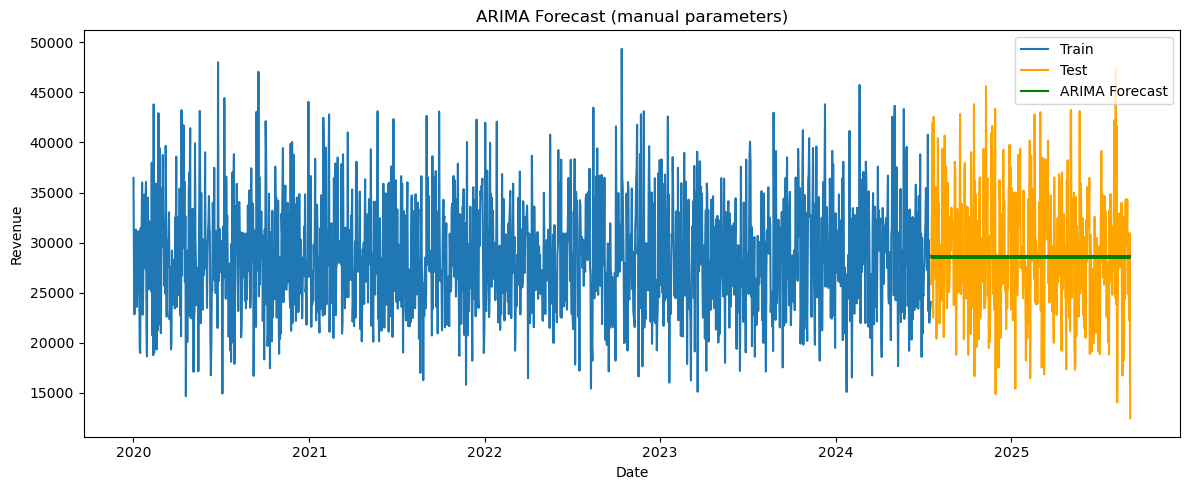

ARIMA Performance:
MSE: 37366658.76, RMSE: 6112.83, MAE: 4817.18, MAPE: 17.68%


In [19]:
#Q3 

#ARIMA (AutoRegressive Integrated Moving Average)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate daily revenue
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Aggregate to daily total revenue
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['Revenue'].sum()
daily_sales.index = pd.to_datetime(daily_sales.index)  # Convert index to datetime
daily_sales = daily_sales.asfreq('D')  # Set frequency to daily
daily_sales = daily_sales.fillna(0)    # Fill missing days with 0

# Split into training and testing sets
train_size = int(len(daily_sales) * 0.8)
train = daily_sales[:train_size]
test = daily_sales[train_size:]

# Manually set ARIMA(p,d,q) parameters (auto_arima didn't work well)
# These values can be adjusted based on ACF/PACF or trial and error
model = ARIMA(train, order=(2, 1, 2))
fitted_model = model.fit()

# Forecast the test period
forecast = fitted_model.forecast(steps=len(test))

# Plot results
plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='green')
plt.title('ARIMA Forecast (manual parameters)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation metrics
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100  # Avoid division by zero
    return mse, rmse, mae, mape

mse, rmse, mae, mape = evaluate(test.values, forecast.values)
print("ARIMA Performance:")
print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")

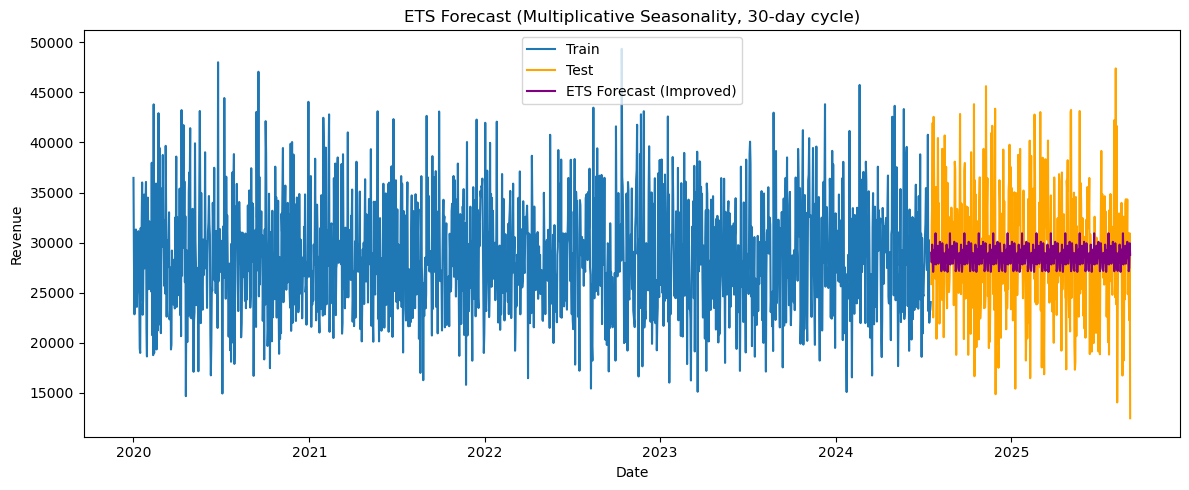

ETS Performance:
MSE: 38006054.76, RMSE: 6164.91, MAE: 4879.23, MAPE: 17.91%


In [21]:
#Exponential Smoothing (ETS)

from statsmodels.tsa.holtwinters import ExponentialSmoothing


ets_model = ExponentialSmoothing(train,
                                 trend=None,
                                 seasonal='mul',
                                 seasonal_periods=30).fit()

# Forecast the same period as the test set
ets_forecast = ets_model.forecast(steps=len(test))

# Plot ETS forecast
plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(test.index, ets_forecast, label='ETS Forecast (Improved)', color='purple')
plt.title('ETS Forecast (Multiplicative Seasonality, 30-day cycle)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation
mse_ets, rmse_ets, mae_ets, mape_ets = evaluate(test.values, ets_forecast.values)
print("ETS Performance:")
print(f"MSE: {mse_ets:.2f}, RMSE: {rmse_ets:.2f}, MAE: {mae_ets:.2f}, MAPE: {mape_ets:.2f}%")


In [25]:
!pip install prophet


   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   --- ------------------------------------ 1.2/13.3 MB 25.1 MB/s eta 0:00:01
   -------- ------------------------------- 2.8/13.3 MB 29.8 MB/s eta 0:00:01
   ------------- -------------------------- 4.4/13.3 MB 31.7 MB/s eta 0:00:01
   ------------------- -------------------- 6.5/13.3 MB 34.6 MB/s eta 0:00:01
   ------------------------- -------------- 8.3/13.3 MB 35.6 MB/s eta 0:00:01
   ---------------------------- ----------- 9.7/13.3 MB 34.3 MB/s eta 0:00:01
   -------------------------------- ------- 11.0/13.3 MB 34.4 MB/s eta 0:00:01
   ------------------------------------- -- 12.5/13.3 MB 34.4 MB/s eta 0:00:01
   ---------------------------------------  13.3/13.3 MB 32.8 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 28.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/94.5 kB ? eta -:--:--
   ---------------------------------------- 94.5/94.5 kB 5.3 MB/s eta 0:00:0

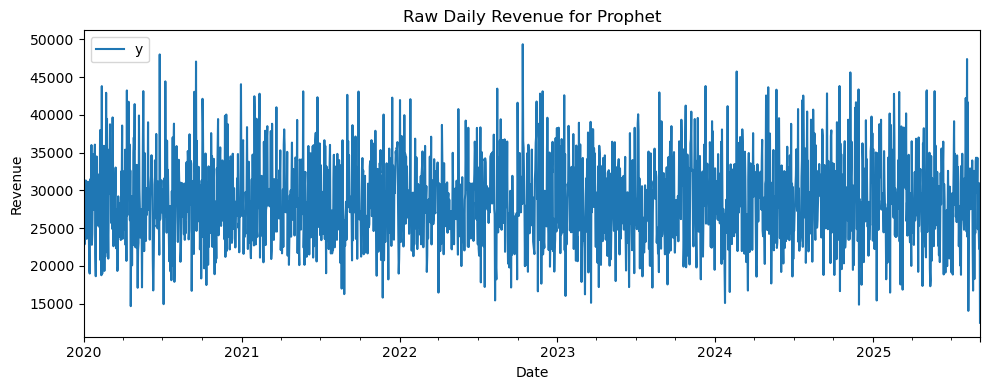

20:57:20 - cmdstanpy - INFO - Chain [1] start processing
20:57:20 - cmdstanpy - INFO - Chain [1] done processing


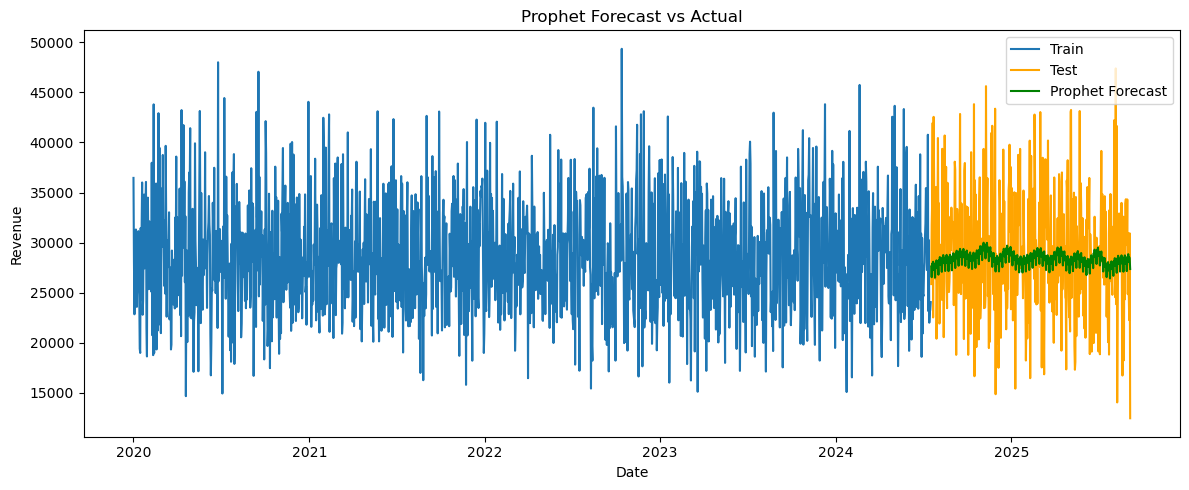

Prophet Performance:
MSE: 37666466.67, RMSE: 6137.30, MAE: 4848.68, MAPE: 17.66%


In [27]:
#Prophet evaluation


from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Prepare data for Prophet
prophet_df = daily_sales.reset_index().rename(columns={'InvoiceDate': 'ds', 'Revenue': 'y'})


prophet_df.plot(x='ds', y='y', title='Raw Daily Revenue for Prophet', figsize=(10, 4))
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

# Split data into train and test (80/20 split)
train_size = int(len(prophet_df) * 0.8)
train_df = prophet_df.iloc[:train_size]
test_df = prophet_df.iloc[train_size:]

# Initialize Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False  # daily seasonality not useful in aggregated daily data
)

# Fit the model on training data
model.fit(train_df)

# Create future dataframe for prediction (same length as test set)
future = model.make_future_dataframe(periods=len(test_df), freq='D')

# Forecast
forecast = model.predict(future)

# Extract only the forecasted part matching test period
forecast_test = forecast.iloc[-len(test_df):]

# Plot forecast vs actual
plt.figure(figsize=(12, 5))
plt.plot(train_df['ds'], train_df['y'], label='Train')
plt.plot(test_df['ds'], test_df['y'], label='Test', color='orange')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Prophet Forecast', color='green')
plt.title('Prophet Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation metrics
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100
    return mse, rmse, mae, mape

mse_p, rmse_p, mae_p, mape_p = evaluate(test_df['y'].values, forecast_test['yhat'].values)
print("Prophet Performance:")
print(f"MSE: {mse_p:.2f}, RMSE: {rmse_p:.2f}, MAE: {mae_p:.2f}, MAPE: {mape_p:.2f}%")
